In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/Kolmogorov


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories
from tools.ae_v1 import Autoencoder

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-02-08 04:43:48.511847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 04:43:48.512546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 04:43:48.573117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 04:43:48.573566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 04:43:48.573964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # loading data directory
    data_dir_idx = '000'

    # making ae save directory
    dir_name_ae = os.getcwd() + dir_sep + 'saved_ae'
    if not os.path.isdir(dir_name_ae):
        os.makedirs(dir_name_ae)

    counter = 0
    while True:
        dir_check = 'ae_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ae + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ae = dir_name_ae + dir_sep + dir_check
    os.makedirs(dir_name_ae)
    os.makedirs(dir_name_ae+dir_sep+'plots')
else:
    # some paramaters
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_015'.format(ds=dir_sep)

    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
    if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_ae:', dir_name_ae)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with h5py.File(dir_name_data + '/data.h5', 'r') as f:
    t_recorded_samples = np.array(f['t'])
    
    N = int(0.5*(np.array(f['num_wavenumbers'])-1))
    print(N, type(N))
    
    u_ref = np.array(f['u_reference'], dtype=FTYPE)
    v_ref = np.array(f['v_reference'], dtype=FTYPE)

dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000
24 <class 'int'>


In [13]:
all_data = np.empty(shape=(u_ref.shape[0], 2, u_ref.shape[1], u_ref.shape[2]), dtype=FTYPE)
all_data[:, 0, :, :] = u_ref
del(u_ref)
all_data[:, 1, :, :] = v_ref
del(v_ref)

In [14]:
# dealing with normalizing the data before feeding into autoencoder
if behaviour == 'initialiseAndTrainFromScratch':
    # normalize data before feeding into autoencoder?
    normalizeforae_flag = True
    normalization_type = 'stddev' # could be 'stddev' or 'minmax'
    stddev_multiplier = 3
    
    normalization_constant_arr_aedata = None
    if normalizeforae_flag == True:
        normalization_constant_arr_aedata = np.empty(shape=(2,) + tuple(all_data.shape[1:]), dtype=FTYPE)
        if normalization_type == 'stddev':
            normalization_constant_arr_aedata[0] = np.mean(all_data, axis=0)
            normalization_constant_arr_aedata[1] = stddev_multiplier * np.std(all_data, axis=0)
        elif normalization_type == 'minmax':
            sample_min = all_data.min(axis=0)
            sample_max = all_data.max(axis=0)
            idx = np.where(sample_min == sample_max)
            if len(idx) > 0:
                num_elems = len(idx[0])
                for i in range(num_elems):
                    i0 = idx[0][i]
                    i1 = idx[1][i]
                    i2 = idx[2][i]
                    sample_min[i0, i1, i2] -= 0.5
                    sample_max[i0, i1, i2] = sample_min[i0, i1, i2] + 1.
            normalization_constant_arr_aedata[0] = sample_min
            normalization_constant_arr_aedata[1] = sample_max - sample_min
        all_data -= normalization_constant_arr_aedata[0]
        all_data /= normalization_constant_arr_aedata[1]
            
    # saving sim data
    ae_data = {
        'data_dir_idx':data_dir_idx,
        'normalizeforae_flag':normalizeforae_flag,
        # 'normalization_constant_arr_aedata':normalization_constant_arr_aedata,
        'normalization_type':normalization_type,
        'stddev_multiplier':stddev_multiplier,
        'ae_data_with_params':False,
        'module':Autoencoder.__module__,
    }
    with open(dir_name_ae+dir_sep+'ae_data.txt', 'w') as f:
        f.write(str(ae_data))
    np.savez(
        dir_name_ae+dir_sep+'normalization_data',
        normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
    )
else:
    if normalizeforae_flag == True:
        all_data -= normalization_constant_arr_aedata[0]
        all_data /= normalization_constant_arr_aedata[1]
            
time_stddev = np.std(all_data, axis=0)

In [15]:
all_data = all_data[::4]

# Autoencoder

In [16]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 200
    patience = 10  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 5e-7 # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 2/100
    timeMeanofSpaceRMS = np.mean(np.mean(all_data**2, axis=1)**0.5)
    
    # stddev = fRMS*timeMeanofSpaceRMS
    stddev = fRMS * np.mean(time_stddev)
    use_weights_post_dense = False
    use_batch_norm = True

    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'use_batch_norm':use_batch_norm,
    }

    with open(dir_name_ae+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        stddev = tparams_dict['stddev']
    except:
        print("'stddev' not in tparams_dict, set to 0")
        stddev = 0.0

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [17]:
# # setting up data
# idx = np.arange(all_data.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round((1-test_split)*all_data.shape[0]))
# training_data = all_data[idx[0:boundary], :]
# testing_data = all_data[idx[boundary:], :]

In [18]:
num_train = int(all_data.shape[0]*train_split)
num_val = int(all_data.shape[0]*val_split)
num_test = all_data.shape[0] - num_train - num_val

idx = np.arange(all_data.shape[0])
np.random.shuffle(idx)

training_data = np.empty(shape=(num_train, ) + tuple(all_data.shape[1:]), dtype=FTYPE)
val_data = np.empty(shape=(num_val, ) + tuple(all_data.shape[1:]), dtype=FTYPE)
testing_data = np.empty(shape=(num_test, ) + tuple(all_data.shape[1:]), dtype=FTYPE)

training_data[:] = all_data[idx[0:num_train]]
val_data[:] = all_data[idx[num_train:num_train+num_val]]
testing_data[:] = all_data[idx[num_train+num_val:]]

In [19]:
del(all_data)

In [20]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    enc_filters = [8, 16, 32, 2]
    dec_filters = [32, 16, 8, 2]
    kernel_size = 3
    
    enc_layer_act_func = 'elu'
    enc_final_layer_act_func = 'tanh'
    dec_layer_act_func = 'elu'
    dec_final_layer_act_func = 'tanh'
    reg_name = 'L2'
    
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(
                data_dim=training_data.shape[1:],
                kernel_size=kernel_size,
                enc_filters=enc_filters, # number of filters
                dec_filters=dec_filters, # number of filters
                lambda_reg=lambda_reg,
                reg_name=reg_name,
                enc_layer_act_func=enc_layer_act_func,
                enc_final_layer_act_func=enc_final_layer_act_func,
                dec_layer_act_func=dec_layer_act_func,
                dec_final_layer_act_func=dec_final_layer_act_func,
                load_file=None,
                stddev=stddev,
                use_weights_post_dense=use_weights_post_dense,
                use_batch_norm=use_batch_norm,)
    else:
        ae_net = Autoencoder(
            data_dim=training_data.shape[1:],
            kernel_size=kernel_size,
            enc_filters=enc_filters, # number of filters
            dec_filters=dec_filters, # number of filters
            lambda_reg=lambda_reg,
            reg_name=reg_name,
            enc_layer_act_func=enc_layer_act_func,
            enc_final_layer_act_func=enc_final_layer_act_func,
            dec_layer_act_func=dec_layer_act_func,
            dec_final_layer_act_func=dec_final_layer_act_func,
            load_file=None,
            stddev=stddev,
            use_weights_post_dense=use_weights_post_dense,
            use_batch_norm=use_batch_norm,)
    # saving the AE configuration
    save_path = dir_name_ae+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    ae_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ae + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(data_dim=training_data.shape[1:], load_file=load_file)
    else:
        ae_net = Autoencoder(data_dim=training_data.shape[1:], load_file=load_file)
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ae+dir_sep+'checkpoints')
        # ae_net.load_weights(wt_file)
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'
        ae_net.load_weights_from_file(wt_file)

2023-02-08 04:43:57.137205: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


In [21]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_ae,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ae+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [22]:
train_MSE_hist = []
val_MSE_hist = []

train_NMSE_hist = []
val_NMSE_hist = []

In [23]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [24]:
if strategy is not None:
    with strategy.scope():
        NMSE_metric = NMSE(divisor_arr=tf.constant(time_stddev))
else:
    NMSE_metric = NMSE(divisor_arr=tf.constant(time_stddev))

In [25]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
#     loss=losses.BinaryCrossentropy(from_logits=False),
    run_eagerly=False,
    metrics=['mse', NMSE_metric]
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            ae_net.load_weights(wt_file)
    else:
        ae_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ae+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=1  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    # training the network
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(ae_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = ae_net.fit(training_data, training_data,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data, val_data),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
313/313 [==============================] - ETA: 0s - loss: 0.0914 - mse: 0.0914 - NMSE: 0.8224 - tot_time: 0h 0m 9.2s

Epoch 1: val_NMSE improved from inf to 0.23202, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 8s 21ms/step - loss: 0.0914 - mse: 0.0914 - NMSE: 0.8224 - val_loss: 0.0259 - val_mse: 0.0258 - val_NMSE: 0.2320
Epoch 2/200
312/313 [============================>.] - ETA: 0s - loss: 0.0210 - mse: 0.0210 - NMSE: 0.1887 - tot_time: 0h 0m 14.4s

Epoch 2: val_NMSE improved from 0.23202 to 0.15503,

Epoch 15/200
312/313 [============================>.] - ETA: 0s - loss: 0.0075 - mse: 0.0075 - NMSE: 0.0671 - tot_time: 0h 1m 22.1s

Epoch 15: val_NMSE did not improve from 0.06847
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0075 - mse: 0.0075 - NMSE: 0.0671 - val_loss: 0.0078 - val_mse: 0.0077 - val_NMSE: 0.0696
Epoch 16/200
311/313 [============================>.] - ETA: 0s - loss: 0.0075 - mse: 0.0074 - NMSE: 0.0663 - tot_time: 0h 1m 27.3s

Epoch 16: val_NMSE improved from 0.06847 to 0.06598, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 17ms/step - loss: 0.0075 - mse: 0.0074 - NMSE: 0.0663 - val_loss: 0.0

Epoch 31/200
310/313 [============================>.] - ETA: 0s - loss: 0.0063 - mse: 0.0062 - NMSE: 0.0554 - tot_time: 0h 2m 44.6s

Epoch 31: val_NMSE did not improve from 0.05475
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0063 - mse: 0.0062 - NMSE: 0.0554 - val_loss: 0.0064 - val_mse: 0.0063 - val_NMSE: 0.0565
Epoch 32/200
312/313 [============================>.] - ETA: 0s - loss: 0.0061 - mse: 0.0060 - NMSE: 0.0537 - tot_time: 0h 2m 49.5s

Epoch 32: val_NMSE improved from 0.05475 to 0.05302, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0061 - mse: 0.0060 - NMSE: 0.0537 - val_loss: 0.0

310/313 [============================>.] - ETA: 0s - loss: 0.0055 - mse: 0.0054 - NMSE: 0.0482 - tot_time: 0h 3m 58.2s

Epoch 46: val_NMSE improved from 0.04743 to 0.04704, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0055 - mse: 0.0054 - NMSE: 0.0482 - val_loss: 0.0054 - val_mse: 0.0052 - val_NMSE: 0.0470
Epoch 47/200
311/313 [============================>.] - ETA: 0s - loss: 0.0055 - mse: 0.0053 - NMSE: 0.0479 - tot_time: 0h 4m 3.1s

Epoch 47: val_NMSE did not improve from 0.04704
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0055 - mse: 0.0053 - NMSE: 0.0479 - val_loss: 0.0054 - val_mse:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0051 - mse: 0.0050 - NMSE: 0.0448 - val_loss: 0.0050 - val_mse: 0.0049 - val_NMSE: 0.0438
Epoch 62/200
310/313 [============================>.] - ETA: 0s - loss: 0.0051 - mse: 0.0050 - NMSE: 0.0446 - tot_time: 0h 5m 17.4s

Epoch 62: val_NMSE improved from 0.04377 to 0.04331, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0051 - mse: 0.0050 - NMSE: 0.0446 - val_loss: 0.0050 - val_mse: 0.0048 - val_NMSE: 0.0433
Epoch 63/200
310/313 [============================>.] - ETA: 0s - loss: 0.0051 - mse: 0.0049 - NMSE: 0.0444 - tot_time: 0h 5m 22.2s

Epoch 6

311/313 [============================>.] - ETA: 0s - loss: 0.0048 - mse: 0.0046 - NMSE: 0.0416 - tot_time: 0h 6m 30.4s

Epoch 77: val_NMSE improved from 0.04061 to 0.04039, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0048 - mse: 0.0046 - NMSE: 0.0416 - val_loss: 0.0046 - val_mse: 0.0045 - val_NMSE: 0.0404
Epoch 78/200
309/313 [============================>.] - ETA: 0s - loss: 0.0047 - mse: 0.0046 - NMSE: 0.0413 - tot_time: 0h 6m 35.3s

Epoch 78: val_NMSE did not improve from 0.04039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0047 - mse: 0.0046 - NMSE: 0.0413 - val_loss: 0.0046 - val_mse

Epoch 93/200
311/313 [============================>.] - ETA: 0s - loss: 0.0045 - mse: 0.0043 - NMSE: 0.0391 - tot_time: 0h 7m 48.8s

Epoch 93: val_NMSE did not improve from 0.03821
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0045 - mse: 0.0043 - NMSE: 0.0391 - val_loss: 0.0044 - val_mse: 0.0043 - val_NMSE: 0.0383
Epoch 94/200
312/313 [============================>.] - ETA: 0s - loss: 0.0045 - mse: 0.0043 - NMSE: 0.0389 - tot_time: 0h 7m 53.6s

Epoch 94: val_NMSE improved from 0.03821 to 0.03816, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0045 - mse: 0.0043 - NMSE: 0.0389 - val_loss: 0.0

Epoch 109/200
310/313 [============================>.] - ETA: 0s - loss: 0.0043 - mse: 0.0042 - NMSE: 0.0375 - tot_time: 0h 9m 7.5s

Epoch 109: val_NMSE did not improve from 0.03681
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0043 - mse: 0.0042 - NMSE: 0.0375 - val_loss: 0.0043 - val_mse: 0.0041 - val_NMSE: 0.0371
Epoch 110/200
313/313 [==============================] - ETA: 0s - loss: 0.0043 - mse: 0.0042 - NMSE: 0.0376 - tot_time: 0h 9m 12.4s

Epoch 110: val_NMSE improved from 0.03681 to 0.03669, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0043 - mse: 0.0042 - NMSE: 0.0376 - val_loss: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 15ms/step - loss: 0.0042 - mse: 0.0041 - NMSE: 0.0368 - val_loss: 0.0041 - val_mse: 0.0040 - val_NMSE: 0.0360
Epoch 126/200
313/313 [==============================] - ETA: 0s - loss: 0.0042 - mse: 0.0041 - NMSE: 0.0366 - tot_time: 0h 10m 29.7s

Epoch 126: val_NMSE did not improve from 0.03565
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 15ms/step - loss: 0.0042 - mse: 0.0041 - NMSE: 0.0366 - val_loss: 0.0042 - val_mse: 0.0040 - val_NMSE: 0.0361
Epoch 127/200
313/313 [==============================] - ETA: 0s - loss: 0.0042 - mse: 0.0041 - NMSE: 0.0368 - tot_time: 0h 10m 34.6s

Epoch 127: val_NMSE did not improve from 0.03565
 - saving loss histories at /home/rkaushik/Documents/Thesis/ML

Epoch 142/200
310/313 [============================>.] - ETA: 0s - loss: 0.0042 - mse: 0.0040 - NMSE: 0.0360 - tot_time: 0h 11m 48.1s

Epoch 142: val_NMSE did not improve from 0.03514
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0042 - mse: 0.0040 - NMSE: 0.0361 - val_loss: 0.0041 - val_mse: 0.0040 - val_NMSE: 0.0357
Epoch 143/200
312/313 [============================>.] - ETA: 0s - loss: 0.0042 - mse: 0.0040 - NMSE: 0.0361 - tot_time: 0h 11m 53.0s

Epoch 143: val_NMSE improved from 0.03514 to 0.03514, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0042 - mse: 0.0040 - NMSE: 0.0360 - val_los

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 15ms/step - loss: 0.0041 - mse: 0.0039 - NMSE: 0.0355 - val_loss: 0.0041 - val_mse: 0.0039 - val_NMSE: 0.0354
Epoch 159/200
313/313 [==============================] - ETA: 0s - loss: 0.0041 - mse: 0.0039 - NMSE: 0.0355 - tot_time: 0h 13m 11.4s

Epoch 159: val_NMSE did not improve from 0.03477
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0041 - mse: 0.0039 - NMSE: 0.0355 - val_loss: 0.0040 - val_mse: 0.0039 - val_NMSE: 0.0350
Epoch 160/200
313/313 [==============================] - ETA: 0s - loss: 0.0041 - mse: 0.0040 - NMSE: 0.0356 - tot_time: 0h 13m 16.3s

Epoch 160: val_NMSE did not improve from 0.03477
 - saving loss histories at /home/rkaushik/Documents/Thesis/ML

Epoch 175/200
313/313 [==============================] - ETA: 0s - loss: 0.0041 - mse: 0.0039 - NMSE: 0.0351 - tot_time: 0h 14m 29.5s

Epoch 175: val_NMSE did not improve from 0.03443
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0041 - mse: 0.0039 - NMSE: 0.0351 - val_loss: 0.0040 - val_mse: 0.0038 - val_NMSE: 0.0345
Epoch 176/200
311/313 [============================>.] - ETA: 0s - loss: 0.0041 - mse: 0.0039 - NMSE: 0.0351 - tot_time: 0h 14m 34.4s

Epoch 176: val_NMSE improved from 0.03443 to 0.03433, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0041 - mse: 0.0039 - NMSE: 0.0351 - val_los

313/313 [==============================] - ETA: 0s - loss: 0.0040 - mse: 0.0039 - NMSE: 0.0348 - tot_time: 0h 15m 52.6s

Epoch 192: val_NMSE improved from 0.03408 to 0.03401, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0040 - mse: 0.0039 - NMSE: 0.0348 - val_loss: 0.0039 - val_mse: 0.0038 - val_NMSE: 0.0340
Epoch 193/200
309/313 [============================>.] - ETA: 0s - loss: 0.0040 - mse: 0.0039 - NMSE: 0.0347 - tot_time: 0h 15m 57.6s

Epoch 193: val_NMSE did not improve from 0.03401
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0040 - mse: 0.0039 - NMSE: 0.0347 - val_loss: 0.0040 - va

Epoch 8/200
310/313 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 0.0037 - NMSE: 0.0329 - tot_time: 0h 18m 4.0s

Epoch 8: val_NMSE did not improve from 0.03247
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 15ms/step - loss: 0.0038 - mse: 0.0037 - NMSE: 0.0329 - val_loss: 0.0038 - val_mse: 0.0036 - val_NMSE: 0.0325
Epoch 9/200
312/313 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 0.0037 - NMSE: 0.0329 - tot_time: 0h 18m 8.9s

Epoch 9: val_NMSE improved from 0.03247 to 0.03246, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0038 - mse: 0.0037 - NMSE: 0.0329 - val_loss: 0.0038 

310/313 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 0.0036 - NMSE: 0.0328 - tot_time: 0h 19m 23.3s

Epoch 24: val_NMSE did not improve from 0.03235
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0038 - mse: 0.0037 - NMSE: 0.0329 - val_loss: 0.0038 - val_mse: 0.0036 - val_NMSE: 0.0324
Epoch 25/200
313/313 [==============================] - ETA: 0s - loss: 0.0038 - mse: 0.0036 - NMSE: 0.0328 - tot_time: 0h 19m 28.3s

Epoch 25: val_NMSE did not improve from 0.03235
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0038 - mse: 0.0036 - NMSE: 0.0328 - val_loss: 0.0038 - val_mse: 0.0036 - val_NMSE: 0.0324
Epoch 26/200
310/313 [============================>.] - ETA: 0s - loss: 0.0038 

Epoch 41/200
309/313 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 0.0036 - NMSE: 0.0327 - tot_time: 0h 20m 47.3s

Epoch 41: val_NMSE improved from 0.03224 to 0.03224, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0038 - mse: 0.0036 - NMSE: 0.0327 - val_loss: 0.0037 - val_mse: 0.0036 - val_NMSE: 0.0322
Epoch 42/200
312/313 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 0.0036 - NMSE: 0.0327 - tot_time: 0h 20m 52.2s

Epoch 42: val_NMSE did not improve from 0.03224
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0038 - mse: 0.0036 - NMSE: 0.0327 - val_loss: 0

Epoch 2/200
310/313 [============================>.] - ETA: 0s - loss: 0.0037 - mse: 0.0036 - NMSE: 0.0323 - tot_time: 0h 22m 6.7s

Epoch 2: val_NMSE did not improve from 0.03206
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 16ms/step - loss: 0.0038 - mse: 0.0036 - NMSE: 0.0324 - val_loss: 0.0037 - val_mse: 0.0036 - val_NMSE: 0.0321
Epoch 3/200
310/313 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 0.0036 - NMSE: 0.0324 - tot_time: 0h 22m 11.5s

Epoch 3: val_NMSE did not improve from 0.03206
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000/checkpoints/LossHistoriesCheckpoint
313/313 [==============================] - 5s 15ms/step - loss: 0.0038 - mse: 0.0036 - NMSE: 0.0324 - val_loss: 0.0037 - val_mse: 0.0036 - val_NMSE: 0.0321
Epoch 4/200
311/313 [============================>.] - ETA: 0s - loss: 

In [26]:
ae_net.encoder_net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 50, 50)]       0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 2, 50, 50)        0         
 se)                                                             
                                                                 
 conv2d (Conv2D)             (None, 8, 25, 25)         144       
                                                                 
 batch_normalization (BatchN  (None, 8, 25, 25)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 8, 25, 25)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 13, 13)        1152  

In [27]:
ae_net.decoder_net.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2, 4, 4)]         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 6, 6)         576       
 nspose)                                                         
                                                                 
 cropping2d (Cropping2D)     (None, 32, 4, 4)          0         
                                                                 
 batch_normalization_5 (Batc  (None, 32, 4, 4)         128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 32, 4, 4)          0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 9, 9)         9216

In [28]:
ae_net.ae_net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2, 50, 50)]       0         
                                                                 
 model (Functional)          (None, 2, 4, 4)           16056     
                                                                 
 model_1 (Functional)        (None, 2, 50, 50)         17406     
                                                                 
Total params: 33,462
Trainable params: 31,752
Non-trainable params: 1,710
_________________________________________________________________


In [30]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_metrics = ae_net.evaluate(
        testing_data, testing_data,
    )
    train_metrics = ae_net.evaluate(training_data, training_data)
    val_metrics = ae_net.evaluate(val_data, val_data)

    save_path = dir_name_ae+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'val_MSE_hist':val_MSE_hist,
            'train_MSE_hist':train_MSE_hist,
            'val_NMSE_hist':val_NMSE_hist,
            'train_NMSE_hist':train_NMSE_hist,
            'lr_change':lr_change,
            'test_loss':test_metrics[0],
            'test_mse':test_metrics[1],
            'train_loss':train_metrics[0],
            'train_mse':train_metrics[1],
            'val_loss':val_metrics[0],
            'val_mse':val_metrics[1],
        }))

    ae_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

79/79 [==============================] - 1s 6ms/step - loss: 0.0038 - mse: 0.0036 - NMSE: 0.0328


In [ ]:
print('lr_change : ', lr_change)

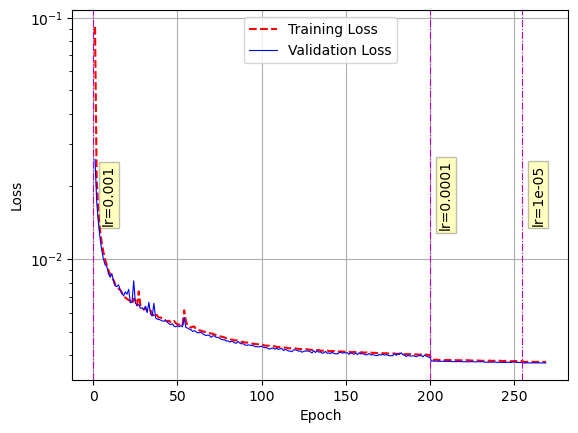

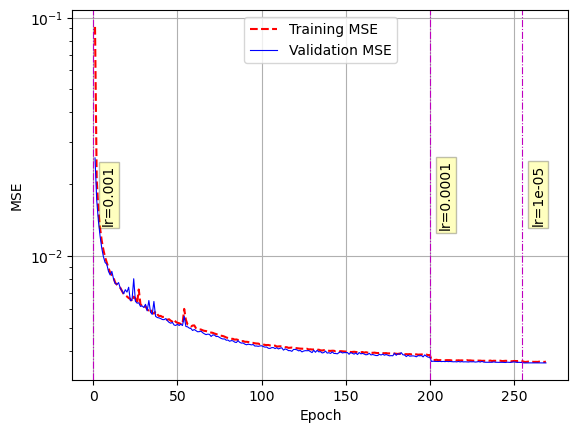

<Figure size 640x480 with 0 Axes>

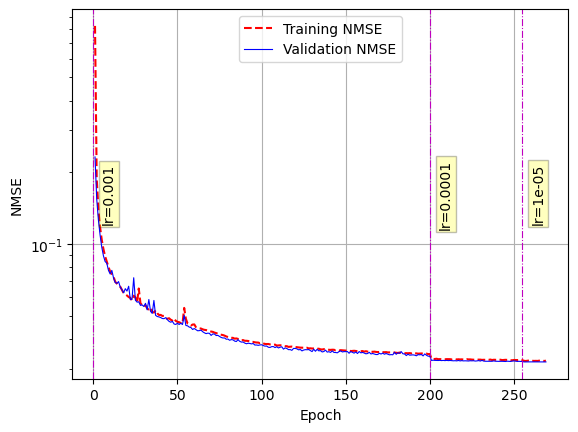

<Figure size 640x480 with 0 Axes>

In [31]:
# plotting losses
dir_name_plot = dir_name_ae + '/plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_plot + '{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

# POD Comparison

In [32]:
pod_training_data = np.empty(shape=(training_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]))
pod_training_data[:, :] = np.reshape(training_data, (training_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]))

pod_centering_means = np.mean(pod_training_data, axis=0)
pod_mean_centered_data = pod_training_data - pod_centering_means

In [33]:
C = np.transpose(pod_mean_centered_data) @ pod_mean_centered_data
C /= pod_mean_centered_data.shape[0] - 1

In [36]:
eigenvals, eigenvecs = np.linalg.eig(C)

In [49]:
abs_eigenvals = np.abs(eigenvals)
idx = np.argsort(abs_eigenvals)

In [50]:
idx = idx[::-1]
W = eigenvecs[:, idx[0:4*4*enc_filters[-1]]]

In [51]:
reconstructed_val_data = val_data.reshape(val_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]) @ W @ W.transpose()
reconstructed_val_data = np.reshape(reconstructed_val_data, val_data.shape)

In [52]:
val_recon_MSE = np.reshape((reconstructed_val_data - val_data)**2, (val_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]))
val_recon_MSE = np.mean(np.sum(val_recon_MSE, axis=1), axis=0)

In [56]:
print(val_recon_MSE, val_recon_MSE/np.sum(time_stddev**2), np.sum(time_stddev**2))

(33.50498242976434+0j) (0.060308983097448636+0j) 555.5554


In [54]:
abs_eigenvals[idx[0:4*4*2]]

array([141.06480022, 127.16714509,  98.61910161,  91.65162949,
         5.56133   ,   5.22346317,   4.68067162,   4.42568335,
         4.19825384,   4.0372301 ,   2.4475167 ,   2.31831582,
         2.13058072,   1.98340622,   1.86565824,   1.82063678,
         1.80347498,   1.75448435,   1.72730789,   1.65783234,
         1.62272897,   1.56117176,   1.50364009,   1.32153963,
         1.24070886,   1.21754198,   1.19416454,   1.17101344,
         1.15816117,   1.14939802,   1.13011238,   1.09943646])

# KE and Dissipation